In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np

2024-12-09 11:30:50.354964: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 11:30:50.418395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Clustering and Dimentionnality Reduction

<div class="alert alert-block alert-danger">

1. Import the CIFAR-10 dataset using the following code and create a new dataset containing only the following classes: "airplane," "automobile," "bird," and "cat."

<div/>

<div class="alert alert-block alert-warning">The CIFAR-10 dataset is composed of 60000 RGB images( 32x32 pixels), categorized into 10 classes with 6000 images per class. It is divided into 50000 training images and 10000 test images.
<div/>

In [2]:
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
# summarize loaded dataset
print('train: X=%s, y=%s' % (x_train.shape, y_train.shape))

train: X=(50000, 32, 32, 3), y=(50000, 1)


In [3]:
print('test: X=%s, y=%s' % (x_test.shape, y_test.shape))

test: X=(10000, 32, 32, 3), y=(10000, 1)


<div class="alert alert-block alert-danger">

2. Visualize some samples from the dataset with their corresponding labels.

<div/>

In [38]:
target_classes = ['airplane', 'automobile', 'bird', 'cat']
target_indices = [label_names.index(cls) for cls in target_classes]

train_mask = np.isin(y_train, target_indices).flatten()
x_train_filtered = x_train[train_mask]
y_train_filtered = y_train[train_mask]

test_mask = np.isin(y_test, target_indices).flatten()
x_test_filtered = x_test[test_mask]
y_test_filtered = y_test[test_mask]

new_label_mapping = {index: i for i, index in enumerate(target_indices)}
y_train_filtered = np.vectorize(new_label_mapping.get)(y_train_filtered)
y_test_filtered = np.vectorize(new_label_mapping.get)(y_test_filtered)

In [5]:
def visualize_samples(images, labels, class_names, num_samples=16):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx][0]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

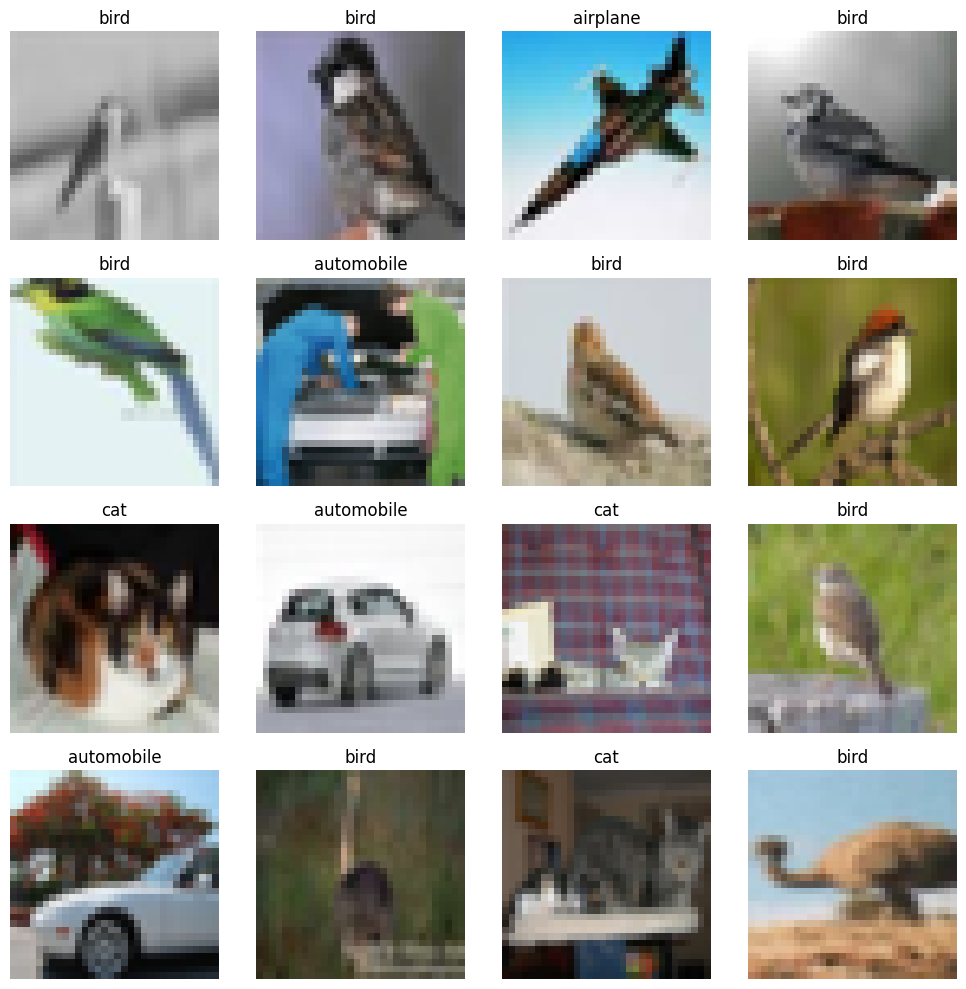

In [6]:
visualize_samples(x_train_filtered, y_train_filtered, target_classes)

<div class="alert alert-block alert-danger">

3. Normalize the training data by dividing all values by 255.

<div/>

In [39]:
print(f"min pixel value: {x_train_filtered.min()}")
print(f"max pixel value: {x_train_filtered.max()}")

min pixel value: 0
max pixel value: 255


In [40]:
x_train_filtered = x_train_filtered.astype('float32') / 255.0
x_test_filtered = x_test_filtered.astype('float32') / 255.0



print(f"min pixel value: {x_train_filtered.min()}")
print(f"max pixel value: {x_train_filtered.max()}")

min pixel value: 0.0
max pixel value: 1.0


<div class="alert alert-block alert-danger">

4. Visualize the data using a 2D plot by applying dimensionality reduction based on PCA with two components.

<div/>

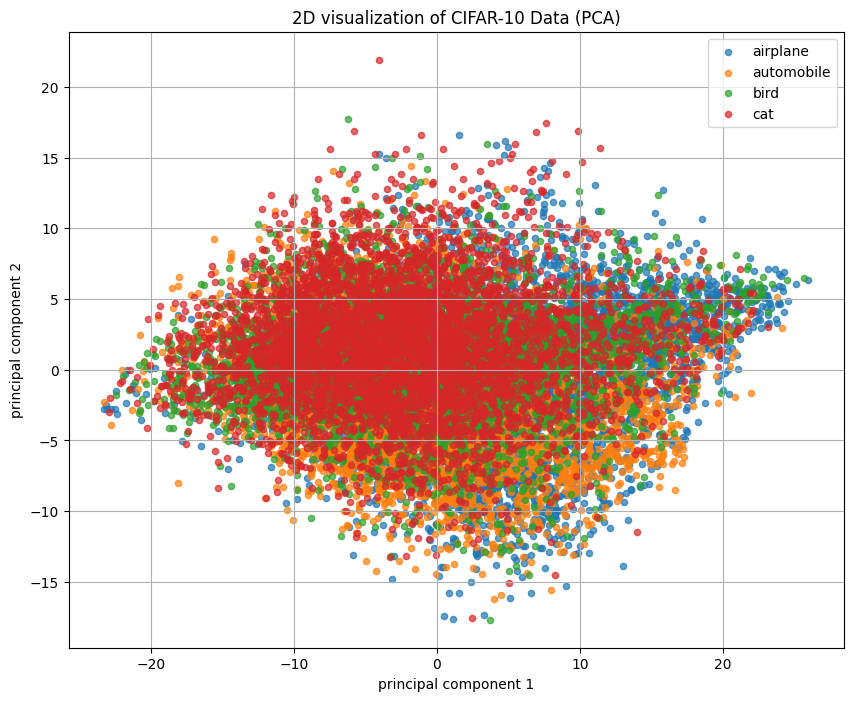

In [12]:
# PCA principal component analysis

# flatten the image data
x_train_flattened = x_train_filtered.reshape(x_train_filtered.shape[0], -1)

# apply PCA to reduce to 2 components
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_flattened)
x_test_pca = pca.transform(x_test_flattened)

# 2D scatter plot
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(target_classes))
for label in np.unique(y_train_filtered):
    idx = y_train_filtered.flatten() == label
    plt.scatter(
        x_train_pca[idx, 0], x_train_pca[idx, 1],
        label=target_classes[label],
        alpha=0.7,
        s=20
    )
plt.legend()
plt.title("2D visualization of CIFAR-10 Data (PCA)")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.grid(True)
plt.show()


<div class="alert alert-block alert-danger">

5. Apply the K-means algorithm, K-means with PCA (with a variance of 95%), and K-means with LDA (3 components) on the normalized training data.

<div/>

In [41]:
x_train_flattened = x_train_filtered.reshape(x_train_filtered.shape[0], -1)
x_test_flattened = x_test_filtered.reshape(x_test_filtered.shape[0], -1)

x_train_flattened[0].shape

(3072,)

In [13]:
# k-means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_train_flattened)

train_labels_kmeans = kmeans.predict(x_train_flattened)
test_labels_kmeans = kmeans.predict(x_test_flattened)

In [14]:
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_flattened)
x_test_pca = pca.transform(x_test_flattened)

kmeans_pca = KMeans(n_clusters=4, random_state=42)
kmeans_pca.fit(x_train_pca)

train_labels_kmeans_pca = kmeans_pca.predict(x_train_pca)
test_labels_kmeans_pca = kmeans_pca.predict(x_test_pca)

In [15]:
# LDA linear discriminant analysis
lda = LinearDiscriminantAnalysis(n_components=3)
x_train_lda = lda.fit_transform(x_train_flattened, y_train_filtered.ravel())
x_test_lda = lda.transform(x_test_flattened)

kmeans_lda = KMeans(n_clusters=4, random_state=42)
kmeans_lda.fit(x_train_lda)

train_labels_kmeans_lda = kmeans_lda.predict(x_train_lda)
test_labels_kmeans_lda = kmeans_lda.predict(x_test_lda)

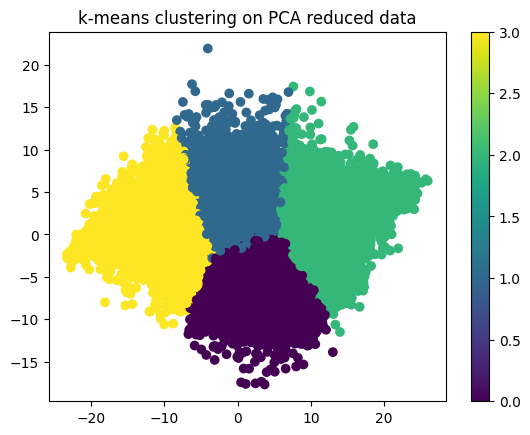

In [16]:
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=train_labels_kmeans_pca, cmap='viridis')
plt.title('k-means clustering on PCA reduced data')
plt.colorbar()
plt.show()


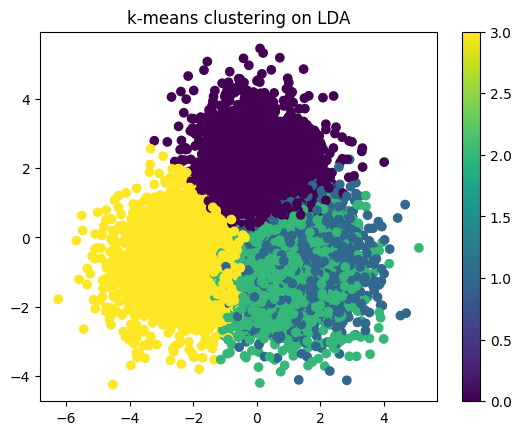

In [17]:
plt.scatter(x_train_lda[:, 0], x_train_lda[:, 1], c=train_labels_kmeans_lda, cmap='viridis')
plt.title('k-means clustering on LDA')
plt.colorbar()
plt.show()

<div class="alert alert-block alert-danger">

6. Visualize the data after clustering using a 2D plot (use PCA with 2 components for dimensionality reduction) for each model. What do you observe?

<div/>

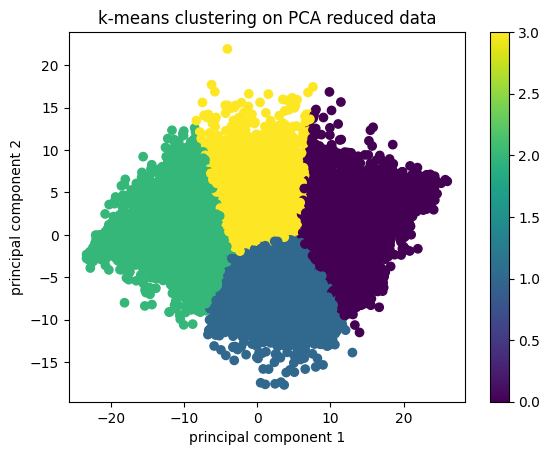

In [18]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_flattened)

train_labels_kmeans = kmeans.fit_predict(x_train_pca)

plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=train_labels_kmeans, cmap='viridis')
plt.title('k-means clustering on PCA reduced data')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.colorbar()
plt.show()

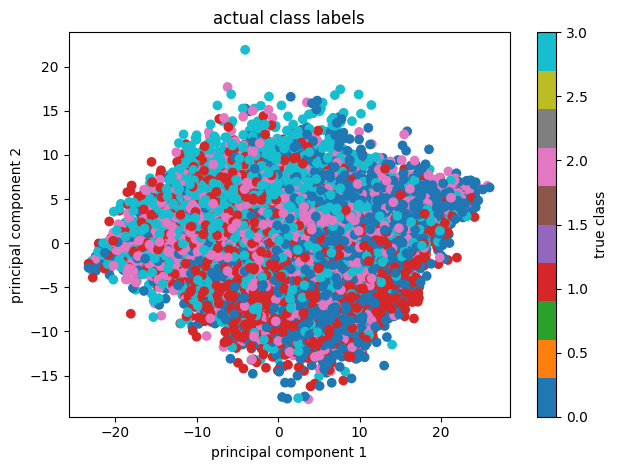

In [19]:
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train_filtered, cmap='tab10')
plt.title('actual class labels')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.colorbar(label='true class')

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-danger">

7. Compute the Davies-Bouldin score for all generated models.

<div/>

In [20]:
# formule = 1/N * sum(max((Si+Sj)/Dji where i != j))
# N: nbr of clusters
# Dji distance between centroids i and j
# Si = avg distance between all points in cluster i and the centroid cluster i
# formule = 1/|Ci| sum(||x-ci||)
# ci centroid, Ci set of points in the cluster i

kmeans_labels = kmeans.fit_predict(x_train_flattened)
db_score_original = davies_bouldin_score(x_train_flattened, kmeans_labels)

kmeans_pca_labels = kmeans.fit_predict(x_train_pca)
db_score_pca = davies_bouldin_score(x_train_pca, kmeans_pca_labels)

kmeans_lda_labels = kmeans.fit_predict(x_train_lda)
db_score_lda = davies_bouldin_score(x_train_lda, kmeans_lda_labels)

print(f"davies-bouldin score (original k-means): {db_score_original}")
print(f"davies-bouldin score (k-means with PCA): {db_score_pca}")
print(f"davies-bouldin score (k-means with LDA): {db_score_lda}")

davies-bouldin score (original k-means): 2.452368156221779
davies-bouldin score (k-means with PCA): 0.9049082613423169
davies-bouldin score (k-means with LDA): 1.0626524970337448


<div class="alert alert-block alert-danger">

8. Display the confusion matrix and the classification reports for all models. What do you observe?

<div/>

In [42]:
kmeans.fit(x_train_flattened)
y_kmeans = kmeans.labels_

kmeans_pca.fit(x_train_pca)
y_kmeans_pca = kmeans_pca.labels_

kmeans_lda.fit(x_train_lda)
y_kmeans_lda = kmeans_lda.labels_

y_train_subset = y_train[:20000]

def print_metrics(true_labels, predicted_labels, model_name):
    print(f"confusion matrix for {model_name}:")
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)
    print(f"\nclassification report for {model_name}:")
    print(classification_report(true_labels, predicted_labels))

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'confusion matrix for {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_train)))
    plt.xticks(tick_marks, np.unique(y_train))
    plt.yticks(tick_marks, np.unique(y_train))

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.tight_layout()
    plt.show()

confusion matrix for original k-means:
[[1802  652 1108 1438]
 [ 566 1712 1075 1647]
 [ 824 1592 1903  681]
 [ 608 1761 1917  714]]

classification report for original k-means:
              precision    recall  f1-score   support

           0       0.47      0.36      0.41      5000
           1       0.30      0.34      0.32      5000
           2       0.32      0.38      0.35      5000
           3       0.16      0.14      0.15      5000

    accuracy                           0.31     20000
   macro avg       0.31      0.31      0.31     20000
weighted avg       0.31      0.31      0.31     20000



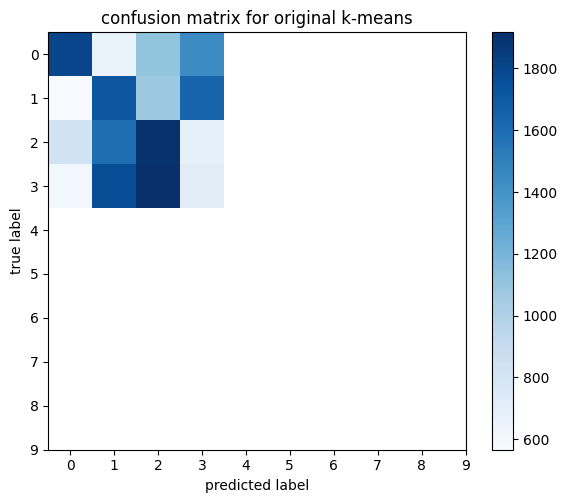

In [45]:
print_metrics(y_train_filtered, y_kmeans, "original k-means")
plot_confusion_matrix(confusion_matrix(y_train_filtered, y_kmeans), "original k-means")

confusion matrix for k-means with PCA:
[[1786 1406  657 1151]
 [ 569 1660 1734 1037]
 [ 832  712 1636 1820]
 [ 607  739 1802 1852]]

classification report for k-means with PCA:
              precision    recall  f1-score   support

           0       0.47      0.36      0.41      5000
           1       0.37      0.33      0.35      5000
           2       0.28      0.33      0.30      5000
           3       0.32      0.37      0.34      5000

    accuracy                           0.35     20000
   macro avg       0.36      0.35      0.35     20000
weighted avg       0.36      0.35      0.35     20000



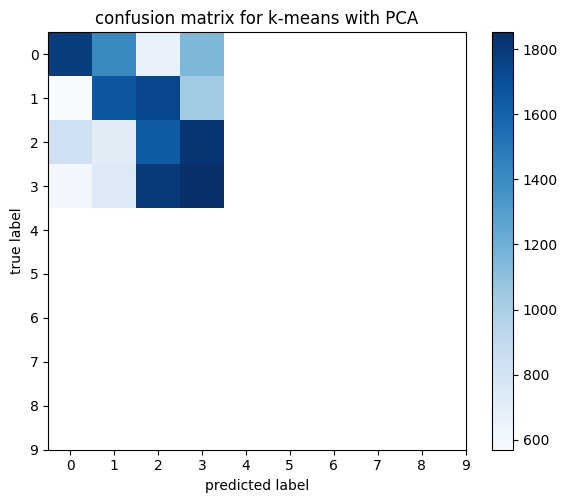

In [46]:
print_metrics(y_train_filtered, y_kmeans_pca, "k-means with PCA")
plot_confusion_matrix(confusion_matrix(y_train_filtered, y_kmeans_pca), "k-means with PCA")

confusion matrix for k-means with LDA:
[[3977  270  463  290]
 [ 525  241  497 3737]
 [ 697 3120  976  207]
 [ 380  636 3678  306]]

classification report for k-means with LDA:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      5000
           1       0.06      0.05      0.05      5000
           2       0.17      0.20      0.18      5000
           3       0.07      0.06      0.06      5000

    accuracy                           0.28     20000
   macro avg       0.25      0.27      0.26     20000
weighted avg       0.25      0.28      0.26     20000



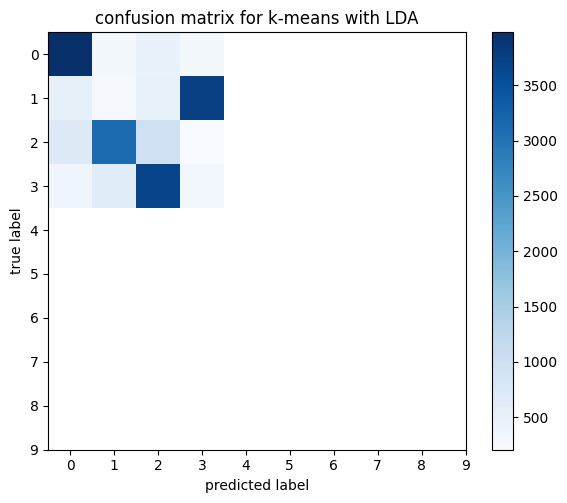

In [47]:
print_metrics(y_train_filtered, y_kmeans_lda, "k-means with LDA")
plot_confusion_matrix(confusion_matrix(y_train_filtered, y_kmeans_lda), "k-means with LDA")

<div class="alert alert-block alert-danger">

9. Display some misclassifications for the best model (image with the true label and predicted label).

<div/>

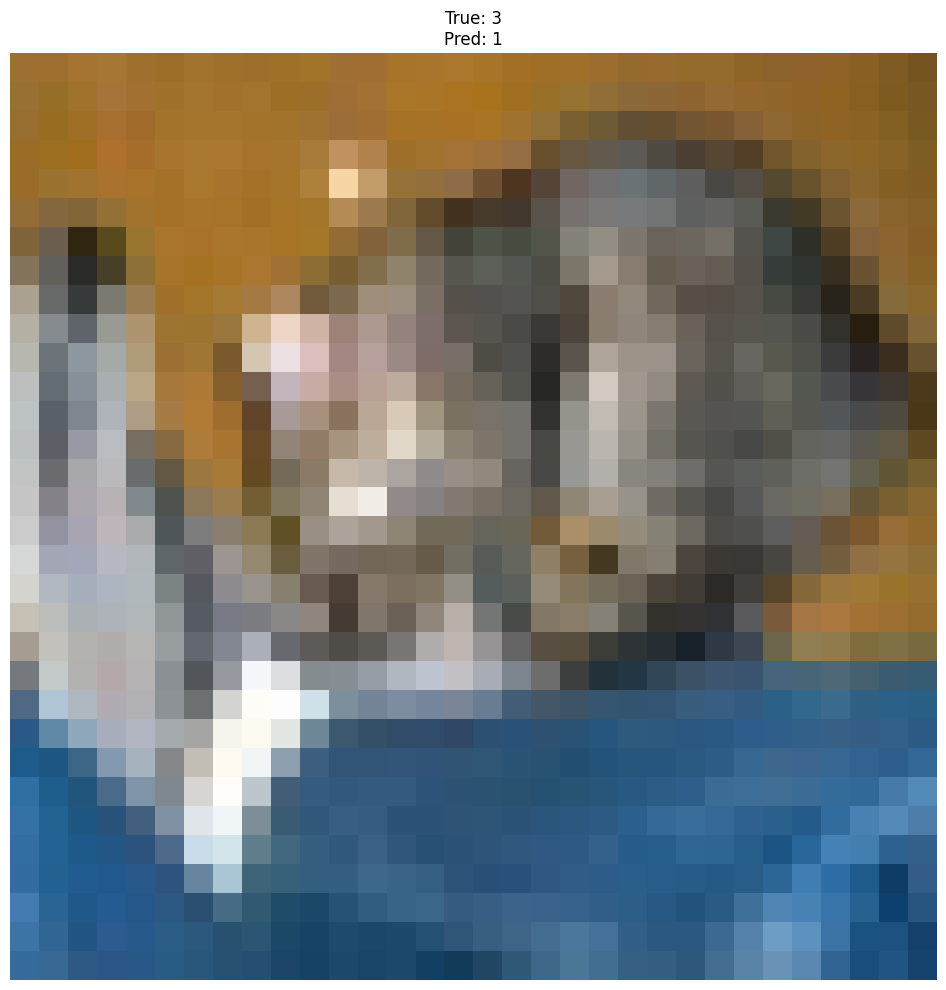

In [ ]:
misclassified_indices = np.where(y_kmeans_pca != y_test)[0]


plt.figure(figsize=(10, 10))
idx = misclassified_indices[0]
    
img = x_test[idx].reshape(32, 32, 3)
true_label = y_test[idx][0]
pred_label = y_kmeans_pca[idx]

plt.imshow(img, cmap='gray')
plt.title(f"True: {true_label}\nPred: {pred_label}")
plt.axis('off')

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-danger">

10. Try to enhance the performance of the best model.

<div/>

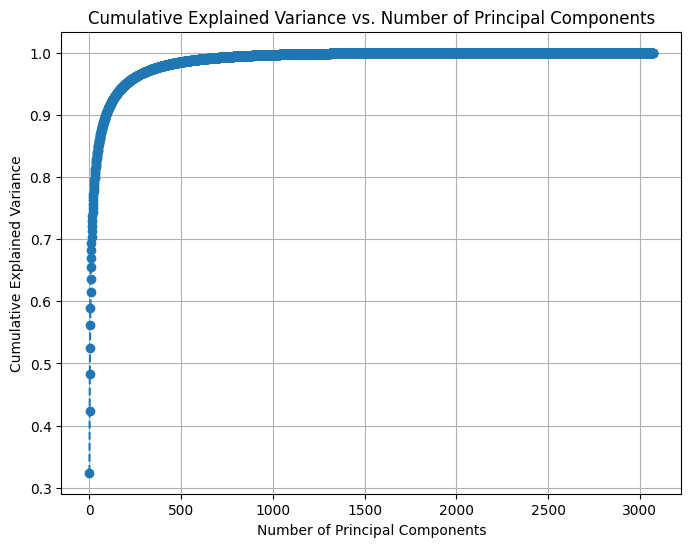

Number of components that explain 95.0% of the variance: 200
Cumulative explained variance with 200 components: 0.9502


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train_flattened)

# calculate the explained variance and cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

def pca_plot(cumulative_explained_variance):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance vs. Number of Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

pca_plot(cumulative_explained_variance)

threshold = 0.95

n_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Number of components that explain {threshold * 100}% of the variance: {n_components}")

pca_optimal = PCA(n_components=n_components)
x_train_pca = pca_optimal.fit_transform(x_train_flattened)

print(f"Cumulative explained variance with {n_components} components: {cumulative_explained_variance[n_components - 1]:.4f}")

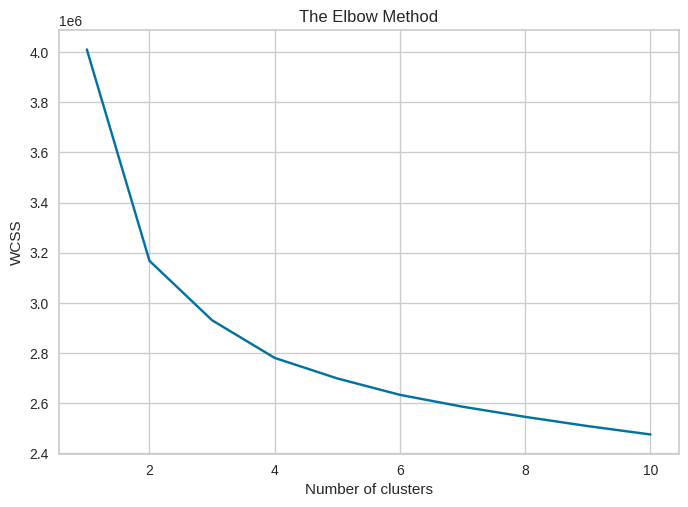

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(x_train_flattened) 
    wcss.append(kmeans.inertia_)  

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [ ]:
silhouette_score(x_train_flattened, kmeans.labels_)

0.05753916

Silhouette Score: 0.10011796653270721


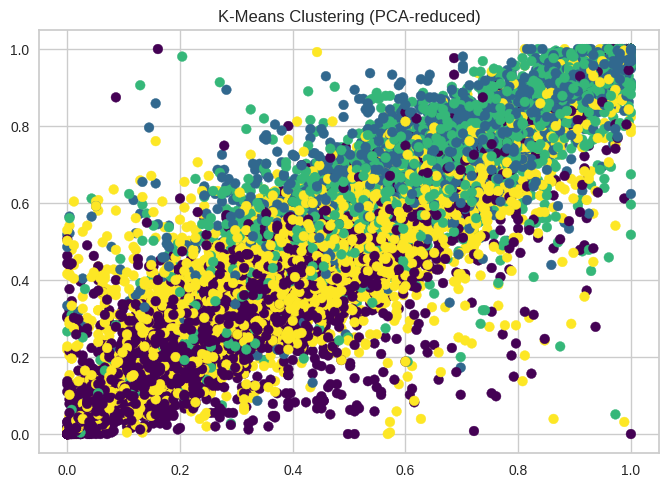

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', n_init=10, random_state=42, max_iter=1000)
kmeans.fit(x_train_flattened)

score = silhouette_score(x_train_flattened, kmeans.labels_)
print(f'Silhouette Score: {score}')

plt.scatter(x_train_flattened[:, 0], x_train_flattened[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-Means Clustering (PCA-reduced)')
plt.show()


In [ ]:
kmeans_pca_labels = kmeans.fit_predict(x_train_pca)
db_score_pca = davies_bouldin_score(x_train_pca, kmeans_pca_labels)

print(f"davies-bouldin score (k-means with PCA): {db_score_pca}")

davies-bouldin score (k-means with PCA): 2.35712044862914


In [ ]:
print(f"y_train shape: {y_train.shape}")
print(f"y_kmeans shape: {y_kmeans.shape}")
print(f"y_kmeans_pca shape: {y_kmeans_pca.shape}")
print(f"y_kmeans_lda shape: {y_kmeans_lda.shape}")


y_train shape: (50000, 1)
y_kmeans shape: (20000,)
y_kmeans_pca shape: (20000,)
y_kmeans_lda shape: (20000,)
